In [11]:
# Instalar bibliotecas
!pip install pmdarima nixtlats

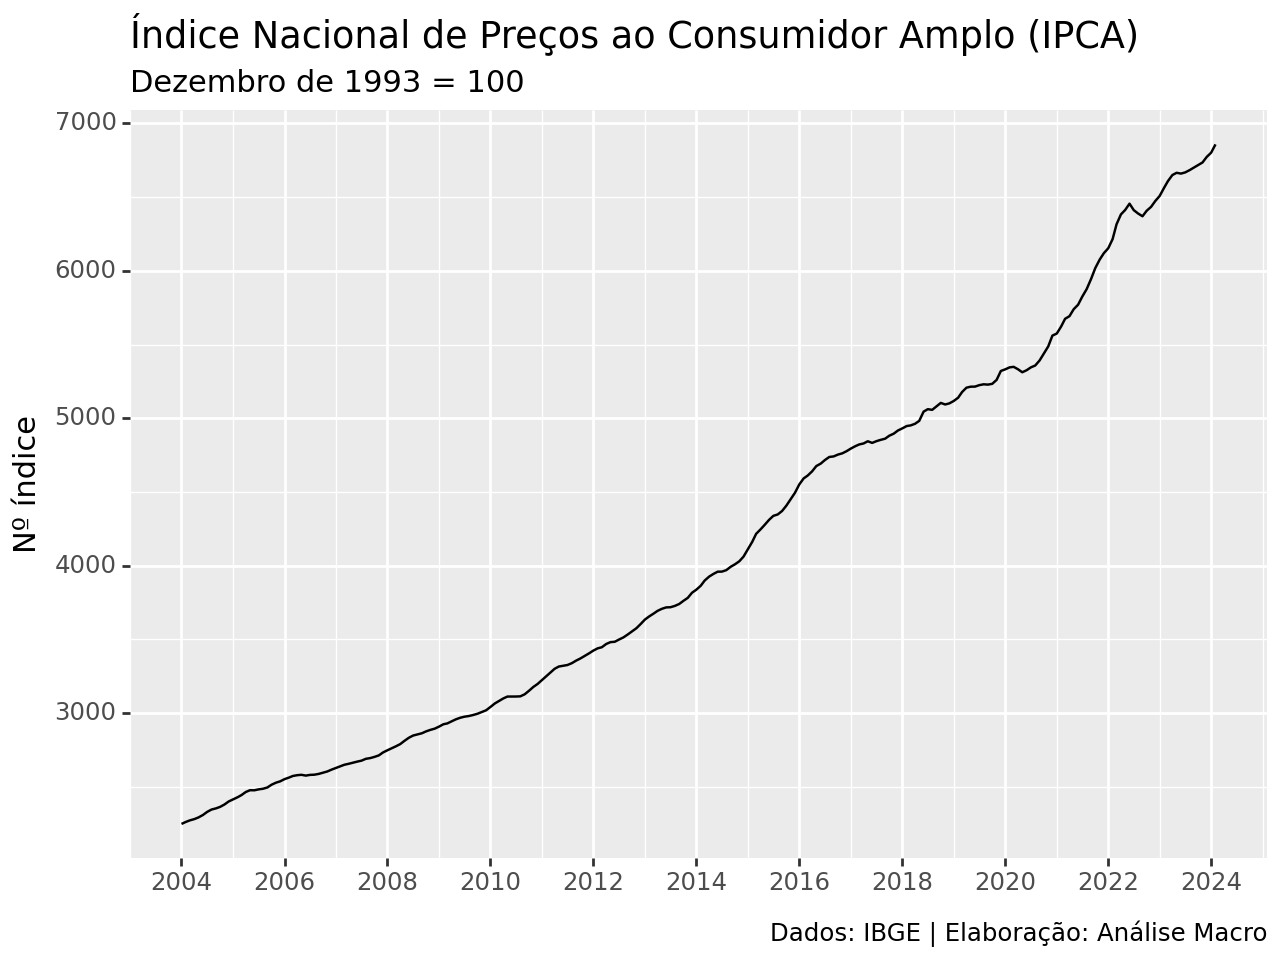

<Figure Size: (640 x 480)>

In [12]:
# Bibliotecas
import pandas as pd
import plotnine as p9
import pmdarima as pmd
import xgboost as xgb
from nixtlats import TimeGPT


# Coleta de dados
dados_brutos = pd.read_json(
  path_or_buf = (
    "https://apisidra.ibge.gov.br/values/t/1737/n1/all/v/2266/p/all/d/" +
    "v2266%2013?formato=json"
    )
)


# Tratamento de dados
dados_tratados = (
  dados_brutos
  .rename(columns = {"V": "valor", "D3C": "data"})
  .query("valor != 'Valor'")
  .assign(
    data = lambda x: pd.to_datetime(x.data, format = "%Y%m"),
    indice = lambda x: x.data,
    valor = lambda x: x.valor.astype(float)
    )
  .query("data >= '2004-01-01'")
  .set_index("indice")
  .filter(items = ["data", "valor"], axis = "columns")
  .asfreq("MS")
)


# Visualização de dados
(
  p9.ggplot(dados_tratados) +
  p9.aes(x = "data", y = "valor") +
  p9.geom_line() +
  p9.scale_x_date(date_breaks = "2 years", date_labels = "%Y") +
  p9.labs(
    title = "Índice Nacional de Preços ao Consumidor Amplo (IPCA)",
    subtitle = "Dezembro de 1993 = 100",
    x = "",
    y = "Nº índice",
    caption = "Dados: IBGE | Elaboração: Análise Macro"
    )
)

/usr/local/lib/python3.10/dist-packages/plotnine/geoms/geom_path.py:98: PlotnineWarning: geom_path: Removed 228 rows containing missing values.


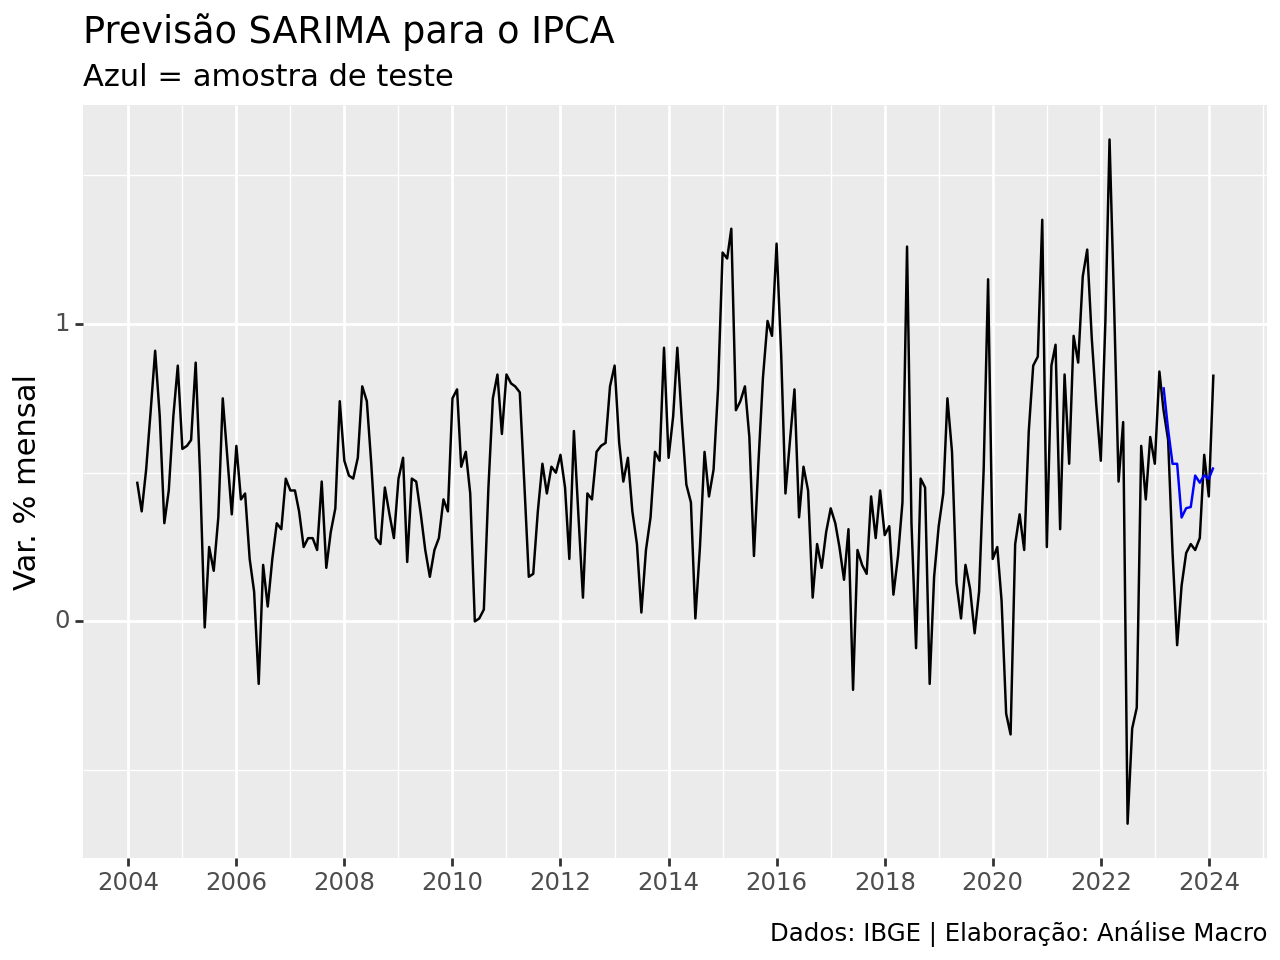

<Figure Size: (640 x 480)>

In [13]:
# Preparação de dados
dados = (
  dados_tratados
  .assign(
    ipca = lambda x: (x.valor / x.valor.shift(1) - 1) * 100,
    ano = lambda x: x.data.dt.year,
    mes = lambda x: x.data.dt.month,
    trimestre = lambda x: x.data.dt.quarter,
    ipca_lag1 = lambda x: x.ipca.shift(1),
    tendencia = lambda x: range(-1, x.shape[0] - 1)
    )
  .dropna()
)


# Separar amostras
dados_teste = dados.tail(12).drop(["data", "valor"], axis = "columns")
y_teste = dados_teste.ipca
x_teste = dados_teste.drop("ipca", axis = "columns")

dados_treino = dados.query("data not in @y_teste.index").drop(
  labels = ["data", "valor"],
  axis = "columns"
  )
y_treino = dados_treino.ipca
x_treino = dados_treino.drop("ipca", axis = "columns")


# Previsão ARIMA ----

# Estimar modelo
ajuste_arima = pmd.auto_arima(y = y_treino, seasonal = True, m = 12)

# Produzir previsões
previsao_arima = ajuste_arima.predict(y_teste.shape[0])

# Gráfico de valores observados e previstos
resultados_arima = pd.DataFrame(
  data = {
    "data": dados.data,
    "y": dados.ipca,
    "previsao": previsao_arima
    },
  index = dados.data
)

(
  p9.ggplot(resultados_arima) +
  p9.aes(x = "data", y = "y") +
  p9.geom_line() +
  p9.geom_line(mapping = p9.aes(y = "previsao"), color = "blue") +
  p9.scale_x_date(date_breaks = "2 years", date_labels = "%Y") +
  p9.labs(
    title = "Previsão SARIMA para o IPCA",
    subtitle = "Azul = amostra de teste",
    x = "",
    y = "Var. % mensal",
    caption = "Dados: IBGE | Elaboração: Análise Macro"
  )
)

/usr/local/lib/python3.10/dist-packages/plotnine/geoms/geom_path.py:98: PlotnineWarning: geom_path: Removed 228 rows containing missing values.


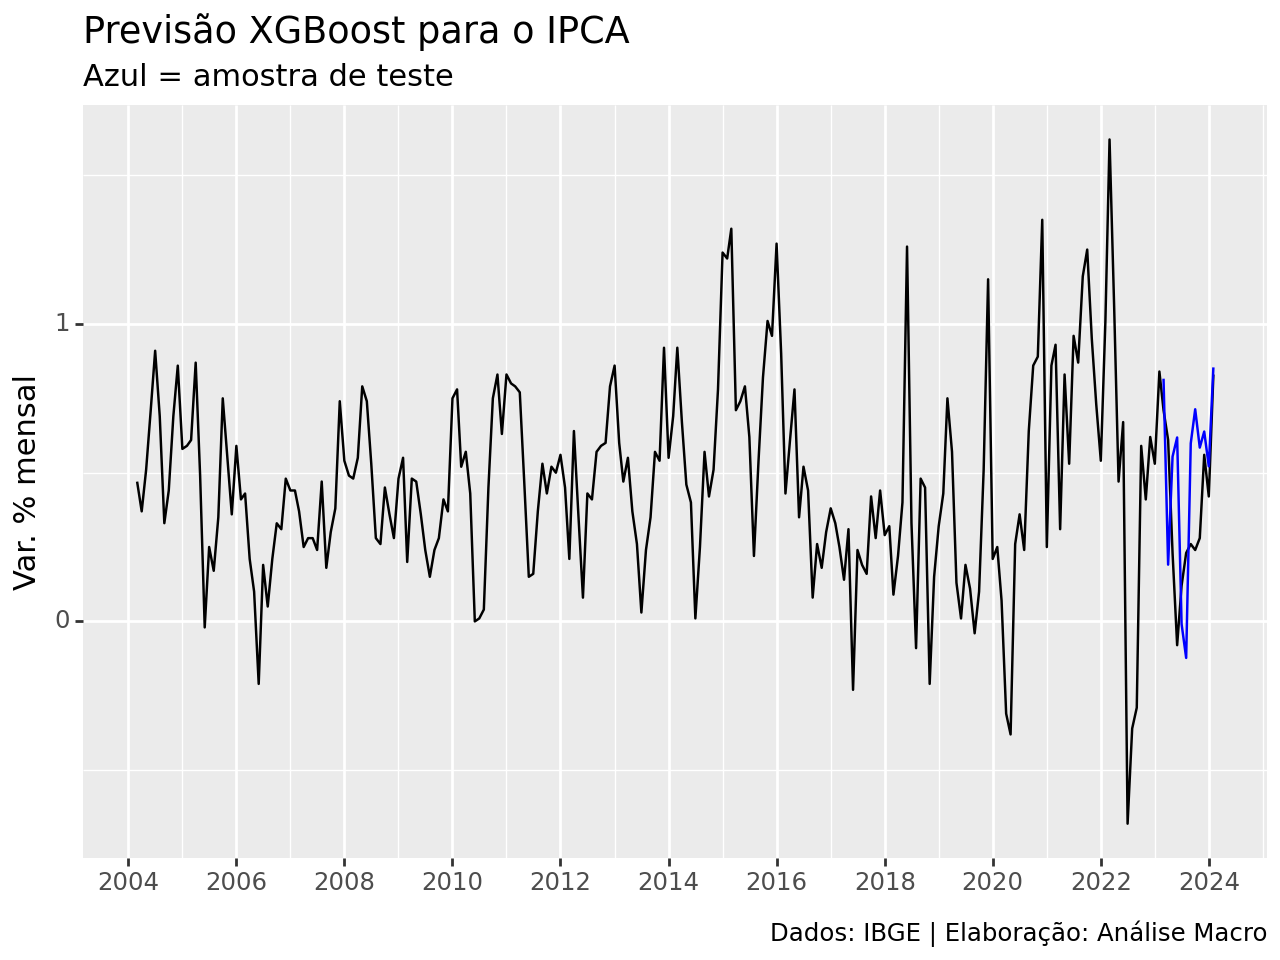

<Figure Size: (640 x 480)>

In [14]:
# Previsão XGBoost ----

# Estimar modelo
ajuste_xgboost = xgb.XGBRegressor().fit(X = x_treino, y = y_treino)

# Produzir previsões
previsao_xgboost = ajuste_xgboost.predict(x_teste)

# Gráfico de valores observados e previstos
resultados_xgboost = pd.DataFrame(
  data = {
    "data": dados.data,
    "y": dados.ipca,
    "previsao": pd.Series(previsao_xgboost, index = previsao_arima.index)
    },
  index = dados.data
)

(
  p9.ggplot(resultados_xgboost) +
  p9.aes(x = "data", y = "y") +
  p9.geom_line() +
  p9.geom_line(mapping = p9.aes(y = "previsao"), color = "blue") +
  p9.scale_x_date(date_breaks = "2 years", date_labels = "%Y") +
  p9.labs(
    title = "Previsão XGBoost para o IPCA",
    subtitle = "Azul = amostra de teste",
    x = "",
    y = "Var. % mensal",
    caption = "Dados: IBGE | Elaboração: Análise Macro"
  )
)

In [15]:
# Previsão TimeGPT ----

# Autenticação na API
# Chave API salva como variável de ambiente os.environ.get("TIMEGPT_TOKEN")
timegpt = TimeGPT()      # acesse o site para obter um token:
timegpt.validate_token() # https://dashboard.nixtla.io/

# Produzir previsões
previsao_timegpt = timegpt.forecast(
  df = dados_treino.assign(data = dados_treino.index),
  X_df = x_teste.assign(data = dados_teste.index),
  target_col = "ipca",
  time_col = "data",
  h = 12,
  freq = "MS"
  )

# Gráfico de valores observados e previstos
resultados_timegpt = pd.DataFrame(
  data = {
    "data": dados.data,
    "y": dados.ipca,
    "previsao": pd.Series(
      previsao_timegpt.TimeGPT.values,
      index = previsao_arima.index
      )
    },
  index = dados.data
)

(
  p9.ggplot(resultados_timegpt) +
  p9.aes(x = "data", y = "y") +
  p9.geom_line() +
  p9.geom_line(mapping = p9.aes(y = "previsao"), color = "blue") +
  p9.scale_x_date(date_breaks = "2 years", date_labels = "%Y") +
  p9.labs(
    title = "Previsão TimeGPT para o IPCA",
    subtitle = "Azul = amostra de teste",
    x = "",
    y = "Var. % mensal",
    caption = "Dados: IBGE | Elaboração: Análise Macro"
  )
)

Exception: The token must be set either by passing `token` or by setting the TIMEGPT_TOKEN environment variable.

In [ ]:
# Comparando resultados ----

# Calculando erros
erro_arima = y_teste - previsao_arima
erro_xgboost = y_teste - previsao_xgboost
erro_timegpt = y_teste - previsao_timegpt.TimeGPT.values
erro_passeio_aleatorio = y_teste - y_treino.tail(12).values

# Calculando métrica RMSE
acuracia = pd.DataFrame(
  data = {
    "Modelo": ["ARIMA", "XGBoost", "TimeGPT", "Passeio Aleatório Sazonal"],
    "RMSE": (
      pd.Series((erro_arima.pow(2)).mean()).pow(0.5).values[0],
      pd.Series((erro_xgboost.pow(2)).mean()).pow(0.5).values[0],
      pd.Series((erro_timegpt.pow(2)).mean()).pow(0.5).values[0],
      pd.Series((erro_passeio_aleatorio.pow(2)).mean()).pow(0.5).values[0]
    )
  }
).assign(
  Modelo = lambda x: pd.Categorical(
    x.Modelo,
    categories = x.sort_values(by = "RMSE", ascending = False).Modelo.tolist()
    )
  )

# Visualização de dados
(
  p9.ggplot(acuracia) +
  p9.aes(x = "Modelo", y = "RMSE") +
  p9.geom_col() +
  p9.labs(
    title = "Desempenho de modelos na previsão do IPCA",
    subtitle = "Menor = melhor; variável de interesse em var. % mensal",
    caption = (
      "Nota: valores para amostra de 12 meses até " +
      y_teste.index.max().strftime("%m/%Y") +
      " | Elaboração: Análise Macro"
      )
  )
)